# Undistort Dataset
[https://github.com/jayrambhia/Vision/blob/master/OpenCV/C%2B%2B/stereocalibrate.cpp](https://github.com/jayrambhia/Vision/blob/master/OpenCV/C%2B%2B/stereocalibrate.cpp)

In [64]:
class Args:
    uncalibrated_dataset_path = "../../resources/images/uncalibrated/calibration_dataset.npz"
    calibrated_dataset_path = "../../resources/images/calibrated/dataset_1.npz"
    calibration_matrix_path = "../../resources/calibrations/calibration.yml"
    save_calibrated_images = False
    common_points_threshold = 40
args = Args()

In [65]:
from models.dataset.DatasetHelper import openImageDataset, saveImageDataset, load_coefficients
from models.dataset.undistort import undistort_images
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [67]:
rs_rgb, rs_z, zv_rgb, zv_z = openImageDataset(args.uncalibrated_dataset_path)
print(f"Opened dataset containing {len(rs_rgb)} image sets")

# camera matrizes
CM1 = np.identity(3)
CM2 = np.identity(3)

# camera distortion coefficients
D1 = np.zeros(4)
D2 = np.zeros(4)

# image sizes of realsense and zivid
img_rs_size = tuple(reversed(rs_rgb[0].shape[:2]))
img_zv_size = tuple(reversed(rs_rgb[0].shape[:2]))

Opened dataset containing 24 image sets


In [71]:
charucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50) 
charucoBoard = cv2.aruco.CharucoBoard_create(7, 5, 7.5, 5.625, charucoDict)

imagePointsA = []
imagePointsB = []
objectPoints = []

for frameA, frameB in zip(rs_rgb, zv_rgb):
    try:            
        # convert BGR to Gray
        frameA = cv2.cvtColor(frameA, cv2.COLOR_BGR2GRAY)
        frameB = cv2.cvtColor(frameB, cv2.COLOR_BGR2GRAY)

        # Find markers corners
        cornersA, idsA, _ = cv2.aruco.detectMarkers(frameA, charucoDict)
        cornersB, idsB, _ = cv2.aruco.detectMarkers(frameB, charucoDict)
        if not cornersA or not cornersB: raise Exception("No markers detected")

        # find charcuo corners # TODO: try with cameraMatrix/distCoeffs
        retA, cornersA, idsA = cv2.aruco.interpolateCornersCharuco(cornersA, idsA, frameA, charucoBoard)
        retB, cornersB, idsB = cv2.aruco.interpolateCornersCharuco(cornersB, idsB, frameB, charucoBoard)
        if not retA or not retB: raise Exception("Can't interpolate corners")

        # Find common points in both frames (is there a nicer way?)
        objPtsA, imgPtsA = cv2.aruco.getBoardObjectAndImagePoints(charucoBoard, cornersA, idsA)
        objPtsB, imgPtsB = cv2.aruco.getBoardObjectAndImagePoints(charucoBoard, cornersB, idsB)

        # Create dictionary for each frame objectPoint:imagePoint to get common markers detected
        ptsA = {tuple(a):tuple(b) for a, b in zip(objPtsA[:,0], imgPtsA[:,0])}
        ptsB = {tuple(a):tuple(b) for a, b in zip(objPtsB[:,0], imgPtsB[:,0])}
        common = set(ptsA.keys()) & set(ptsB.keys())    # intersection between obj points

        if len(common) < 60: raise Exception("To few respective points found in images")

        # fill arrays where each index specifies one markers objectPoint and both respective imagePoints
        frameObjectPoints = []
        frameImagePointsA = []
        frameImagePointsB = []
        for objP in common:
            frameObjectPoints.append(np.array(objP))
            frameImagePointsA.append(np.array(ptsA[objP]))
            frameImagePointsB.append(np.array(ptsB[objP]))
        imagePointsA.append(np.array(frameImagePointsA))
        imagePointsB.append(np.array(frameImagePointsB))
        objectPoints.append(np.array(frameObjectPoints))

    except Exception as e:
        print(f"Skipped frame: {e}")
        continue

# calculates transformation (T) and rotation (R) between both cameras
results = cv2.stereoCalibrate(
    objectPoints, 
    imagePointsA, 
    imagePointsB, 
    CM1, 
    D1, 
    CM2, 
    D2, 
    img_rs_size, 
    flags=cv2.CALIB_FIX_INTRINSIC
)

_, _, _, _, _, R, T, _, _ = results

Skipped frame: To few respective points found in images
Skipped frame: To few respective points found in images
Skipped frame: Can't interpolate corners
Skipped frame: To few respective points found in images
Skipped frame: To few respective points found in images
Skipped frame: To few respective points found in images
Skipped frame: 'NoneType' object is not subscriptable
Skipped frame: To few respective points found in images
Skipped frame: To few respective points found in images
Skipped frame: No markers detected
Skipped frame: To few respective points found in images
Skipped frame: To few respective points found in images
Skipped frame: Can't interpolate corners
Skipped frame: To few respective points found in images
Skipped frame: To few respective points found in images
Skipped frame: Can't interpolate corners
Skipped frame: To few respective points found in images


[[ 0.81547203  0.57876444  0.00609053]
 [-0.57876519  0.81549221 -0.00181756]
 [-0.00601872 -0.00204282  0.9999798 ]]


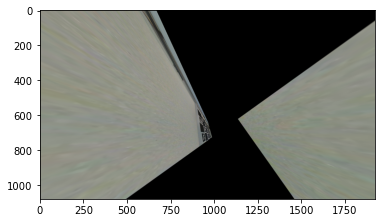

In [70]:
# 
R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(CM1, D1, CM2, D2, img_rs_size, R, T)
map1x, map1y = cv2.initUndistortRectifyMap(CM1, D1, R1, P1, img_rs_size, cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(CM2, D2, R2, P2, img_zv_size, cv2.CV_32FC1)
img1 = rs_rgb[0]
img2 = zv_rgb[0]

imgU1 = cv2.remap(img1, map1x, map1y, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
imgU2 = cv2.remap(img2, map2x, map2y, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

plt.imshow(imgU1)